# Predicting Player Activity on a Minecraft Research Server


### Introduction


In this investigation, we will predict the total hours played by players according to the players.csv dataset. In the study led by Frank Wood, players’ actions and profiles were observed on a Minecraft server. One of the research's key challenges is predicting which types of players are likely to generate large amounts of gameplay data. This information would allow them to target recruitment more effectively and plan the necessary computing resources to operate the server. For the purpose of this report, we will see if the data describing each player in players.csv, which includes 196 observations and 7 variables: (experience, subscription, “hashedEmail,” played hours, name, gender, and age), can predict the total hours played by a player. Below is a summary of the players.csv data set:


|Variable Name | Type | Description |
|---|---|---|
| experience | character | Tells us the player's experience level: beginner, regular, amateur, veteran, or pro  |
|subscribe | logical | Whether the player subscribed to the newsletter (TRUE = subscribed, FALSE = not subscribed), there are 52 players not subscribed and 144 subscribed  |
|hashedemail | character | Encrypted player email identifier  |
|played_hours | numeric | Total number of hours the player has spent playing|
|name | character | Player's name|
| gender | character | Gives the player's gender|
| age | numeric | Player's age in years|


To begin exploring our question, we wanted to choose predictor variables based on those we inferred would have the most impact on predicting the total hours played. We selected gender, age, subscription status, and experience level. Gender and age capture basic demographic differences that may affect gaming habits. Subscription status reflects a player’s level of interest or engagement, which may relate to how much they play. Experience level indicates how comfortable a player is with the game, which can affect how long they stay active on the server. This narrowed down our question to: ***Can the variables of gender, age, subscription, and experience be used to predict the total hours played by a player?***

### Method & Results

##### Loading and Cleaning Data

In [2]:
# Loading Appropriate Packages 
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [9]:
# Loading and Reading Data
players<- read_csv("data/players.csv")

# Wrangling and cleaning data
# 1. Converting categorical variables to factors

clean_players<- players|>
drop_na()|>
select(played_hours, gender, Age,)|>
mutate(gender=as_factor(gender))|>
filter(played_hours > 0) |>
    mutate(age_group = cut(Age, breaks = c(5, 10, 15, 20, 25, 30, 35, 40, 45, 50, Inf), labels = c("5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50+")))


# Relevant summary of the Dataset
summary(clean_players)



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


  played_hours                  gender        Age         age_group 
 Min.   :  0.10   Male             :75   Min.   : 9.0   15-19  :51  
 1st Qu.:  0.10   Female           :21   1st Qu.:17.0   20-24  :35  
 Median :  0.50   Non-binary       : 6   Median :20.0   10-14  : 6  
 Mean   : 10.51   Prefer not to say: 5   Mean   :21.3   25-29  : 6  
 3rd Qu.:  1.80   Agender          : 1   3rd Qu.:23.0   5-9    : 2  
 Max.   :223.10   Two-Spirited     : 1   Max.   :58.0   30-34  : 2  
                                                        (Other): 7  

#### Visuallization for Exploratory Dataset

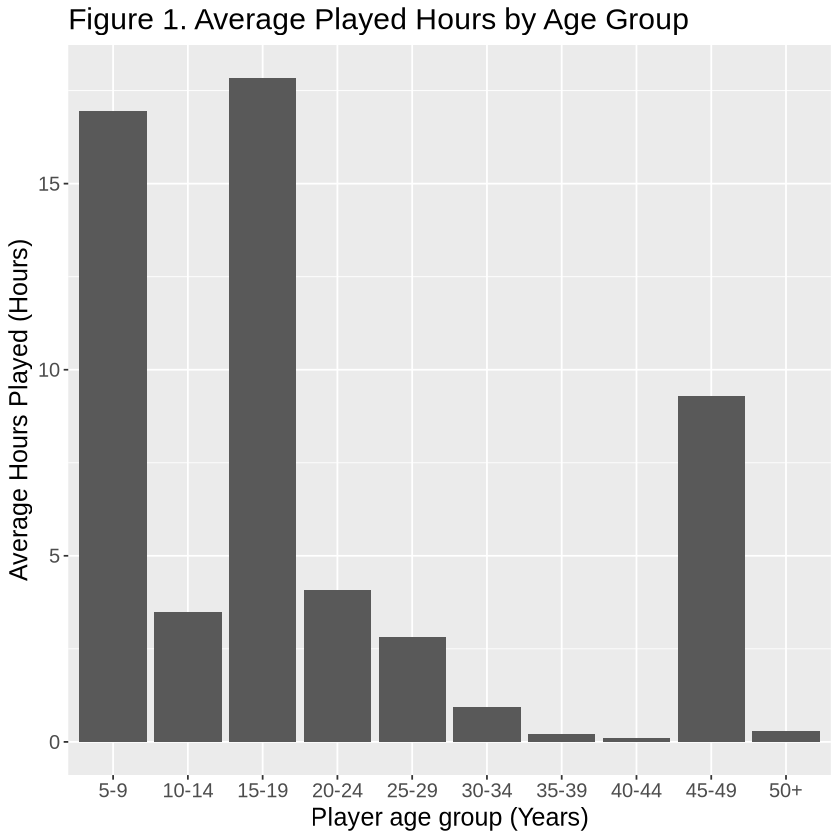

In [10]:
# Figure 1. Average Played Hours by Age Group

avg_hrs_played_by_age_group<- clean_players|>
group_by(age_group)|>
summarise(avg_played_hrs = mean(played_hours))

figure_1<- ggplot(avg_hrs_played_by_age_group, aes(x = age_group, y = avg_played_hrs))+
geom_bar(stat="identity")+
labs( title = "Figure 1. Average Played Hours by Age Group",
     x = "Player age group (Years)",
     y= "Average Hours Played (Hours)")+
        theme(text = element_text(size = 15))



figure_1


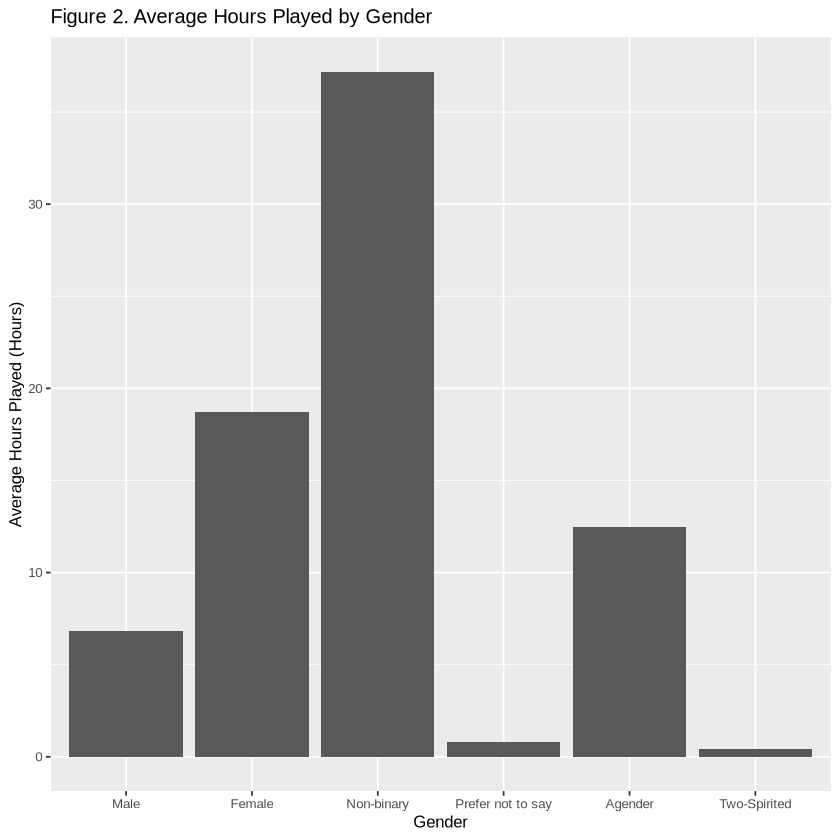

In [11]:
#Figure 2. Average Hours Played by Gender
avg_hours_gender <- clean_players |>
  group_by(gender) |>
  summarise(avg_hours = mean(played_hours))

figure_2 <- ggplot(avg_hours_gender,
                   aes(x = gender, y = avg_hours)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure 2. Average Hours Played by Gender",
    x = "Gender",
    y = "Average Hours Played (Hours)"
  ) +
  theme(text = element_text(size = 10))

figure_2


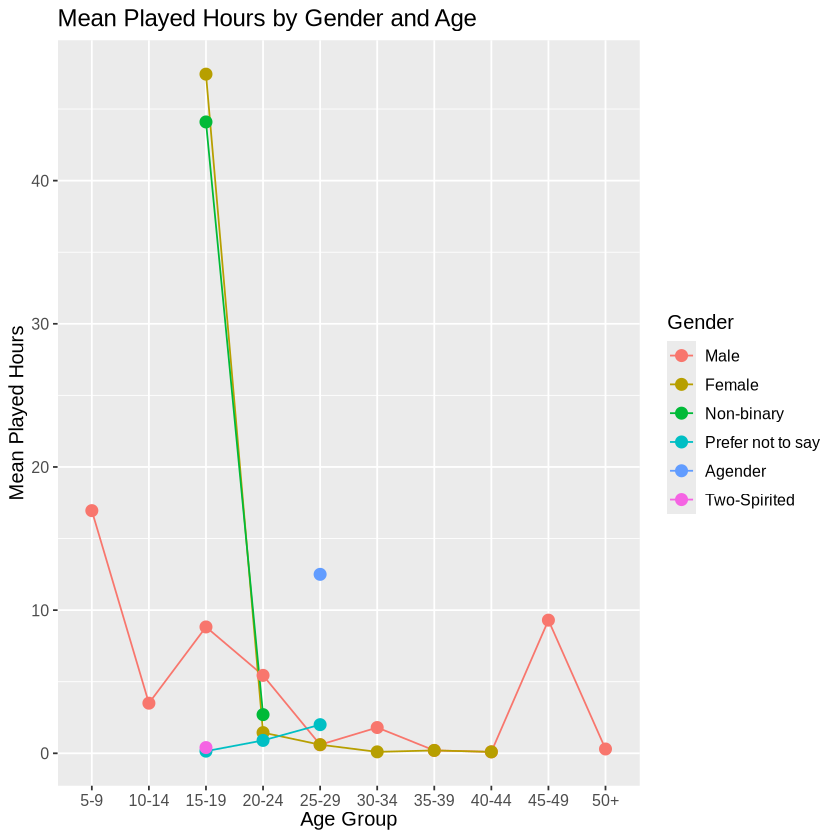

In [22]:
mean_played_hours_by_gender_and_age<- clean_players|>
group_by(age_group, gender)|>
summarise(mean_played_hours = mean(played_hours), .groups="drop")

line_plot<- mean_played_hours_by_gender_and_age|>
ggplot(aes(x=age_group, y= mean_played_hours, group = gender, color = gender))+
geom_line()+
geom_point(size=3)+
labs(x= "Age Group", y = " Mean Played Hours ", color = "Gender")+
theme(text= element_text(size=12))+
ggtitle("Mean Played Hours by Gender and Age")
line_plot



### Data Anaylsis with Linear Regression

In [71]:
library(tidymodels)
set.seed(123)

# Train/test split
data_split <- initial_split(clean_players, prop = 0.75)
train_data <- training(data_split)
test_data  <- testing(data_split)

# Recipe (preprocessing)
player_recipe <- recipe(played_hours ~ Age + gender, data = train_data) |>
  step_dummy(all_nominal_predictors()) |>
  step_normalize(all_numeric_predictors())

# Defining model
lm_model <- linear_reg() |>
  set_engine("lm")

# Workflow
lm_workflow <- workflow() |>
  add_model(lm_model) |>
  add_recipe(player_recipe)

# Fitting model
lm_fit <- fit(lm_workflow, data = train_data)

# Test performance
lm_test_results <- lm_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = played_hours, estimate = .pred)
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,52.168618015
rsq,standard,0.000425236
mae,standard,21.705901583
